# Neural Style Transfer

Using PyTorch

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cuda')

## Defining Input Transforms

In [4]:
IMGSIZE = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize((IMGSIZE, IMGSIZE)),
    transforms.ToTensor()
])

## Loading  Images

In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [6]:
content_image = image_loader("inputs/contents/content.jpg")
style_image = image_loader("inputs/styles/style.jpg")

In [7]:
# assert style_image.size() == content_image.size()


## Function to print Images

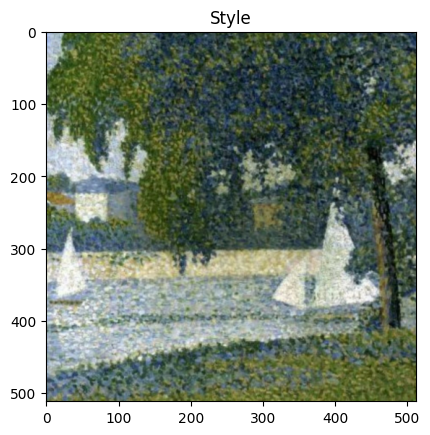

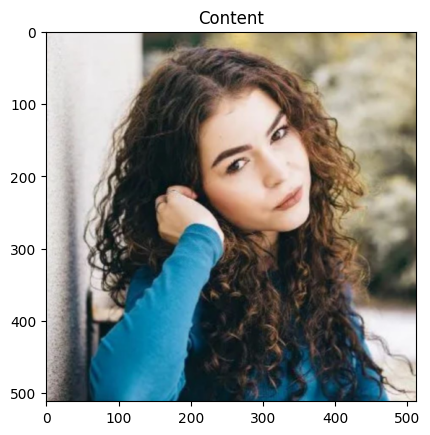

In [8]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title = None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.01)

plt.figure()
imshow(style_image, title = "Style")
plt.figure()
imshow(content_image, title = "Content")

## Loss Function

### Content Loss
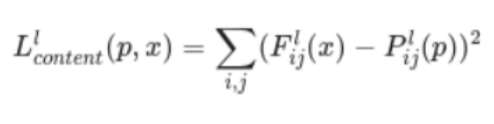

In [9]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
        

### Style Loss

The style loss module is implemented similarly to the content loss
module. It will act as a transparent layer in a
network that computes the style loss of that layer. In order to
calculate the style loss, we need to compute the gram matrix $G_{XL}$. A gram
matrix is the result of multiplying a given matrix by its transposed
matrix. In this application the given matrix is a reshaped version of
the feature maps $F_{XL}$ of a layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$\ x\ $N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is the
length of any vectorized feature map $F_{XL}^k$. For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.

Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield
larger values in the Gram matrix. These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. Style features tend to be in the deeper layers of the
network so this normalization step is crucial.



source : https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [10]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a*b, c*d) #a = 1, b = channels, c, d = height, width
    G = torch.mm(features, features.t())

    return G.div(a*b*c*d)
    

In [11]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()

        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing Model

Importimg VGG19 with pretrained weights

In [12]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

d:\DL\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\DL\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
cnn_normalization_mean = torch.tensor([0.485, .456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, image):
        return (image - self.mean) / self.std

In [14]:
content_layers_default = ["conv_4"]
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(
    cnn, mean, std,style_image, content_image, 
    content_layers = content_layers_default,
    style_layers = style_layers_default):


    normalization = Normalization(mean, std).to(device)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)


        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)


        if name in style_layers:
            # add style loss:
            target_feature = model(style_image).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i+1)]

    return model, style_losses, content_losses


## Gradient Descent

In [15]:
def get_input_optimizer(input_image):
    optimizer = optim.LBFGS([input_image])
    return optimizer

In [16]:
input_image = content_image.clone()

In [17]:
EPOCHS = 200
STYLE_WEIGHT = 1e6
CONTENT_WEIGHT = 1

def run_style_transfer(
    cnn, mean, std, content_image, style_image,
    input_image, num_epocs = EPOCHS, style_weight = STYLE_WEIGHT,
    content_weight =  CONTENT_WEIGHT):
    print("Building Model")
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, mean, std, style_image, content_image
    )

    input_image.requires_grad_(True) # we have to update image parameters
    model.requires_grad_(False) # we are not updating model weights

    optimizer = get_input_optimizer(input_image)

    print("Optimizing....")

    run = [0]
    while run[0] < num_epocs:
        def closure():
            with torch.no_grad():
                input_image.clamp_(0,1) #TODO

            optimizer.zero_grad()
            model(input_image)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score +=sl.loss

            for cl in content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1

            if run[0]%50 == 0:
                print("run{}:".format(run[0]))
                print("Style Loss: {:4f}  Content Loss : {:4f}".format(style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_image.clamp_(0,1)

    return input_image


    

## Running Neural Style Transfer

Building Model


C:\Users\Dell\AppData\Local\Temp\ipykernel_19420\873505614.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1,1,1)
C:\Users\Dell\AppData\Local\Temp\ipykernel_19420\873505614.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing....
run50:
Style Loss: 19.541674  Content Loss : 8.929203

run100:
Style Loss: 7.435295  Content Loss : 7.868518

run150:
Style Loss: 4.048987  Content Loss : 6.755816

run200:
Style Loss: 2.121612  Content Loss : 6.151110



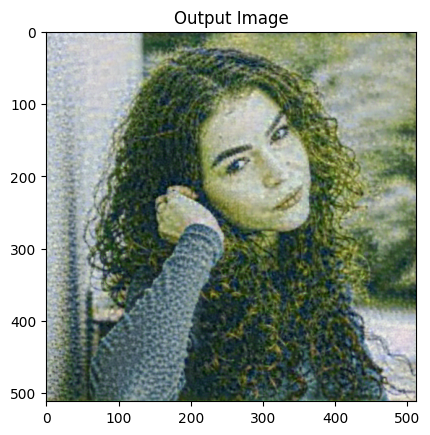

In [18]:
output = run_style_transfer(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    content_image, style_image, input_image
)

plt.figure()

imshow(output, title = "Output Image")

plt.ioff()
plt.show()

## Saving the output

In [19]:
def save(image, filename):
    image = image.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    image.save(f"{filename}.jpg")
    

In [22]:
save(output, "outputs/output")